In [235]:
import os
from typing import List, Tuple
from dataclasses import dataclass
from functools import partial
from uuid import uuid4
import logging 

from keras import Model
from keras_retinanet.models import load_model
from glob import glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [123]:
@dataclass
class BoundingBox:
    left_top: Tuple[int, int]
    right_bottom: Tuple[int, int]

@dataclass
class InferenceResult:
    bbox: BoundingBox
    confidence: float
    label: int

In [124]:
InferenceResults = List[InferenceResult]

In [237]:
INFERENCE_MODEL_PATH = "/home/ppeczek/Dokumenty/models/keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5"
DATA_DIRECTORY_PATH = os.path.abspath("../data/people_detection")
FACE_DETECTION_DIRECTORY_PATH = os.path.abspath("../data/face_detection")

In [261]:
model = load_model(INFERENCE_MODEL_PATH)

tracking <tf.Variable 'Variable_35:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_36:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_37:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_38:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_39:0' shape=(9, 4) dtype=float32> anchors


/home/ppeczek/.local/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [239]:
INPUT_PATHS = glob(os.path.join(DATA_DIRECTORY_PATH, "*.jpg"))

In [240]:
for path in INPUT_PATHS:
    print(path)

/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/8.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/9.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/2.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/4.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/5.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/3.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/7.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/6.jpg
/home/ppeczek/Dokumenty/ModelAsAService/data/people_detection/1.jpg


In [241]:
def load_images(images_paths: List[str]) -> List[np.ndarray]:
    return list(filter(
            lambda i: i is not None,
            map(cv.imread, images_paths)
    ))

In [242]:
INPUT_IMAGES = load_images(images_paths=INPUT_PATHS)

In [243]:
for image in INPUT_IMAGES:
    print(image.shape)

(853, 1280, 3)
(853, 1280, 3)
(853, 1280, 3)
(960, 1280, 3)
(902, 1280, 3)
(869, 1280, 3)
(853, 1280, 3)
(720, 1280, 3)
(959, 640, 3)


In [244]:
CONFIDENCE_THRESHOLD = 0.4
CLASSES_TO_FETCH = {0}

def infer_from_image(image: np.ndarray, 
                     model: Model
                    ) -> InferenceResults:
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    expanded_image = np.expand_dims(image, axis=0)
    boxes, scores, labels = model.predict_on_batch(expanded_image)
    return _post_process_inference(
        boxes=boxes[0],
        scores=scores[0],
        labels=labels[0]
    )
    
def _post_process_inference(boxes: np.ndarray,
                            scores: np.ndarray,
                            labels: np.ndarray
                            ) -> InferenceResults:
    inference_results = []
    for bbox, score, label in zip(boxes, scores, labels):
        if score < CONFIDENCE_THRESHOLD or label not in CLASSES_TO_FETCH:
            continue
        bbox = BoundingBox(
            left_top=(int(round(bbox[0])), int(round(bbox[1]))),
            right_bottom=(int(round(bbox[2])), int(round(bbox[3])))
        )
        inference_result = InferenceResult(
            bbox=bbox,
            confidence=score,
            label=label
        )
        inference_results.append(inference_result)
    return inference_results

In [245]:
COLOURS = {
    0: (0, 255, 0)
}

def visualise_inference_results(input_image: np.ndarray,
                                inference_results: InferenceResults
                                ) -> np.ndarray:
    input_image = input_image.copy()
    for inference_result in inference_results:
        input_image = _draw_bbox(
            input_image=input_image,
            inference_result=inference_result
        )
    return input_image
    
    
def _draw_bbox(input_image: np.ndarray,
               inference_result: InferenceResult
               ) -> np.ndarray:
    color = COLOURS[inference_result.label]
    cv2.rectangle(
        img=input_image,
        pt1=inference_result.bbox.left_top,
        pt2=inference_result.bbox.right_bottom,
        color=color,
        thickness=5
    )
    return input_image

In [246]:
def process_images(images: List[np.ndarray],
                   model: Model
                   ) -> List[np.ndarray]:
    infer = partial(infer_from_image, model=model)
    inference_results = list(map(infer, images))
    return [
        visualise_inference_results(img, inf_res)
        for img, inf_res in zip(images, inference_results)
    ]

In [247]:
processed_images = process_images(
    images=INPUT_IMAGES,
    model=model
)

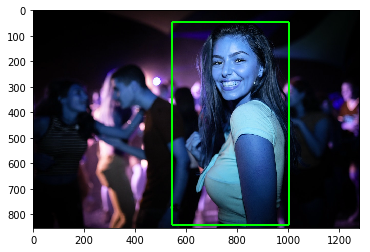

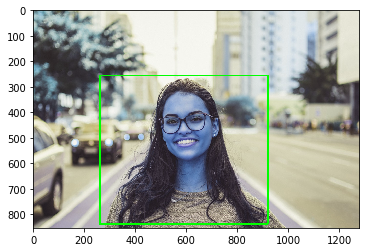

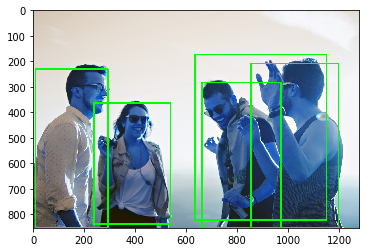

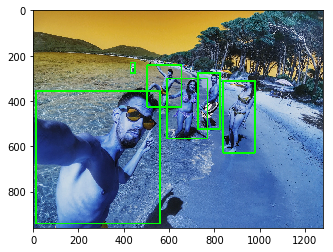

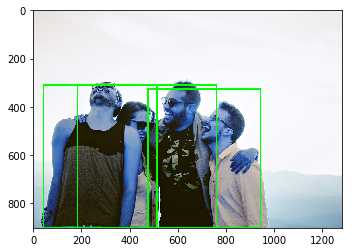

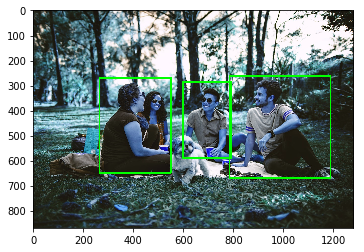

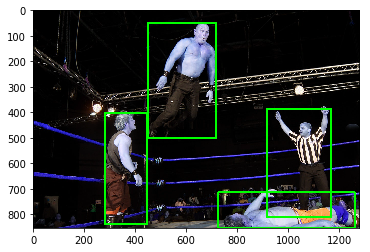

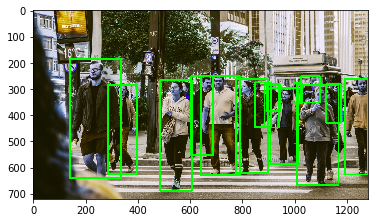

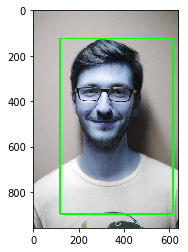

In [248]:
for processed_image in processed_images:
    plt.imshow(processed_image)
    plt.show()

In [259]:
def extract_objects_crops(input_images: List[np.ndarray],
                          target_dir_path: str,
                          model: Model
                          ) -> None:
    infer = partial(infer_from_image, model=model)
    infers_results = list(map(infer, input_images))
    for image, infer_results in zip(input_images, infers_results):
        _save_detected_objects(
            image=image,
            detected_objects=infer_results,
            target_dir_path=target_dir_path
        )
        
def _save_detected_objects(image: np.ndarray,
                           detected_objects: InferenceResults,
                           target_dir_path: str
                           ) -> None:
    detection_dir = os.path.join(target_dir_path, f"{uuid4()}")
    os.makedirs(detection_dir, exist_ok=False)
    for idx, detected_object in enumerate(detected_objects):
        _save_crop(
            image=image,
            detected_object=detected_object,
            target_path=os.path.join(detection_dir, f"{idx}.jpg")
        )

def _save_crop(image: np.ndarray,
               detected_object: InferenceResult,
               target_path: str
               ) -> None:
    detection_bbox = detected_object.bbox
    (x_min, y_min), (x_max, y_max) = \
        detection_bbox.left_top, detection_bbox.right_bottom
    crop = image[y_min:y_max, x_min:x_max]
    if crop.size > 0:
        cv.imwrite(target_path, crop)
    else:
        logging.info("Crop has 0-size and is dropped.")

In [260]:
extract_objects_crops(
    input_images=INPUT_IMAGES,
    target_dir_path=FACE_DETECTION_DIRECTORY_PATH,
    model=model
)